In [0]:
import numpy as np
import pandas as pd
# !/local_disk0/.ephemeral_nfs/envs/pythonEnv-d9c08a49-d864-4604-bf2b-5684c40ebdc8/bin/python -m pip install --upgrade pip
# !pip install pyspark plotly dask hvplot pyarrow --upgrade
# !pip install -U scikit-learn --upgrade
# !pip install kaggle --upgrade
import os
import plotly.express as px
from pyspark.sql import SparkSession
import pyarrow.feather as feather
import pyspark as spark
import pyspark.pandas as ps
from pyspark.ml.feature import *

In [0]:
# !kaggle datasets download -d vlad15lav/mts-ml-cup

100%|█████████████████████████████████████▊| 1.20G/1.20G [00:18<00:00, 70.3MB/s]
100%|██████████████████████████████████████| 1.20G/1.20G [00:18<00:00, 70.6MB/s]


In [0]:
# !mv /dbfs/FileStore/tables/kaggle.json /root/.kaggle/kaggle.json
# !chmod 600 /root/.kaggle/kaggle.json

In [0]:
# !ls

azure		      ganglia			  mts-ml-cup.zip
conf		      hadoop_accessed_config.lst  preload_class.lst
dataset_full.feather  logs			  submission.feather
eventlogs	      mts-ml-cookies.zip	  target_train.feather


In [0]:
# !unzip mts-ml-cup.zip

Archive:  mts-ml-cup.zip
  inflating: part-00000-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet  
  inflating: part-00001-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet  
  inflating: part-00002-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet  
  inflating: part-00003-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet  
  inflating: part-00004-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet  
  inflating: part-00005-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet  
  inflating: part-00006-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet  
  inflating: part-00007-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet  
  inflating: part-00008-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet  
  inflating: part-00009-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet  
  inflating: public_train.pqt        
  inflating: sample_submit.csv       
  inflating: submit_2.pqt            


In [0]:
# conf = spark.SparkConf().setAll([('spark.executor.memory', '16g'),('spark.driver.memory','16g')])
# conf = spark.SparkConf().setAll([('spark.executor.memory', '8g'), ('spark.executor.cores', '3'), ('spark.cores.max', '3'), ('spark.driver.memory','8g')])
spark = SparkSession.builder.getOrCreate()

In [0]:
spark.version

Out[26]: '3.3.0'

In [0]:
DATA_PATH = '/FileStore/tables/transformed.parquet'

In [0]:
# !ls /databricks/driver

In [0]:
# !ls /dbfs/

In [0]:
orig_df = spark.read.parquet(*[i for i in os.listdir('/dbfs/') if 'part' in i])

In [0]:
orig_df.show(5)

+------------------+---------+---------------------+--------------+--------------------+-----------+-----------------+-------+----------+-----------+-----------+-------+
|       region_name|city_name|cpe_manufacturer_name|cpe_model_name|            url_host|cpe_type_cd|cpe_model_os_type|  price|      date|part_of_day|request_cnt|user_id|
+------------------+---------+---------------------+--------------+--------------------+-----------+-----------------+-------+----------+-----------+-----------+-------+
|Краснодарский край|Краснодар|                Apple|      iPhone 7|       ad.adriver.ru| smartphone|              iOS|20368.0|2022-06-15|    morning|          1|  45098|
|Краснодарский край|Краснодар|                Apple|      iPhone 7|           apple.com| smartphone|              iOS|20368.0|2022-06-19|    morning|          1|  45098|
|Краснодарский край|Краснодар|                Apple|      iPhone 7|avatars.mds.yande...| smartphone|              iOS|20368.0|2022-06-12|        day| 

In [0]:
orig_df.count()

Out[30]: 322899435

In [0]:
train = spark.read.parquet('/FileStore/tables/public_train.pqt')

In [0]:
train = train.select(train.columns[:-1])
train.show(5)

+----+-------+-------+
| age|is_male|user_id|
+----+-------+-------+
|31.0|      1| 350459|
|35.0|      1| 188276|
|41.0|      0|  99002|
|33.0|      0| 155506|
|54.0|      0| 213873|
+----+-------+-------+
only showing top 5 rows



In [0]:
orig_df = orig_df.join(train, on='user_id', how='left')

In [0]:
orig_df.count()

Out[54]: 322899435

In [0]:
orig_df.show(5)

+-------+------------------+---------+---------------------+--------------+--------------------+-----------+-----------------+-------+----------+-----------+-----------+----+-------+
|user_id|       region_name|city_name|cpe_manufacturer_name|cpe_model_name|            url_host|cpe_type_cd|cpe_model_os_type|  price|      date|part_of_day|request_cnt| age|is_male|
+-------+------------------+---------+---------------------+--------------+--------------------+-----------+-----------------+-------+----------+-----------+-----------+----+-------+
|  45098|Краснодарский край|Краснодар|                Apple|      iPhone 7|       ad.adriver.ru| smartphone|              iOS|20368.0|2022-06-15|    morning|          1|null|   null|
|  45098|Краснодарский край|Краснодар|                Apple|      iPhone 7|           apple.com| smartphone|              iOS|20368.0|2022-06-19|    morning|          1|null|   null|
|  45098|Краснодарский край|Краснодар|                Apple|      iPhone 7|avatars.md

In [0]:
city_coords = spark.read.option("header",True).csv('/FileStore/tables/city_cord.csv')
city_coords = city_coords.selectExpr("city as city_name", 'lat', 'lng')

In [0]:
city_coords.show(5)

+---------+----------+----------+
|city_name|       lat|       lng|
+---------+----------+----------+
|    Галич| 49.123317|24.7299495|
|    Белёв| 53.811798| 36.137001|
|     Тара|47.3900474| 0.6889268|
| Межгорье|54.2410247|57.9736815|
|  Дербент| 42.057858|48.2887648|
+---------+----------+----------+
only showing top 5 rows



In [0]:
orig_df = orig_df.join(city_coords, on='city_name', how='left')

In [0]:
orig_df.show(5)

+---------+-------+------------------+---------------------+--------------+--------------------+-----------+-----------------+-------+----------+-----------+-----------+----+-------+----------+----------+
|city_name|user_id|       region_name|cpe_manufacturer_name|cpe_model_name|            url_host|cpe_type_cd|cpe_model_os_type|  price|      date|part_of_day|request_cnt| age|is_male|       lat|       lng|
+---------+-------+------------------+---------------------+--------------+--------------------+-----------+-----------------+-------+----------+-----------+-----------+----+-------+----------+----------+
|Краснодар|  45098|Краснодарский край|                Apple|      iPhone 7|       ad.adriver.ru| smartphone|              iOS|20368.0|2022-06-15|    morning|          1|null|   null|45.7684014|39.0261044|
|Краснодар|  45098|Краснодарский край|                Apple|      iPhone 7|           apple.com| smartphone|              iOS|20368.0|2022-06-19|    morning|          1|null|   nul

In [0]:
for col in orig_df.columns:
    print(f'Null values in {col}', orig_df.select(col).where(f'{col} is null').count())

Null values in city_name 0
Null values in user_id 0
Null values in region_name 0
Null values in cpe_manufacturer_name 0
Null values in cpe_model_name 0
Null values in url_host 0
Null values in cpe_type_cd 0
Null values in cpe_model_os_type 0
Null values in price 6589482
Null values in date 0
Null values in part_of_day 0
Null values in request_cnt 0
Null values in age 112169426
Null values in is_male 112186695
Null values in lat 0
Null values in lng 0
Null values in price_out 0


In [0]:
imputer = Imputer()
imputer.setInputCols(["price"])
imputer.setOutputCols(["price_out"])
model = imputer.fit(orig_df)
orig_df = model.transform(orig_df)

In [0]:
orig_df = orig_df.drop('price')

In [0]:
df = orig_df

In [0]:
df.show(5)

+---------+-------+------------------+---------------------+--------------+--------------------+-----------+-----------------+----------+-----------+-----------+----+-------+----------+----------+---------+
|city_name|user_id|       region_name|cpe_manufacturer_name|cpe_model_name|            url_host|cpe_type_cd|cpe_model_os_type|      date|part_of_day|request_cnt| age|is_male|       lat|       lng|price_out|
+---------+-------+------------------+---------------------+--------------+--------------------+-----------+-----------------+----------+-----------+-----------+----+-------+----------+----------+---------+
|Краснодар|  45098|Краснодарский край|                Apple|      iPhone 7|       ad.adriver.ru| smartphone|              iOS|2022-06-15|    morning|          1|null|   null|45.7684014|39.0261044|  20368.0|
|Краснодар|  45098|Краснодарский край|                Apple|      iPhone 7|           apple.com| smartphone|              iOS|2022-06-19|    morning|          1|null|   nul

In [0]:
cat_cols = ['region_name', 'city_name', 'cpe_manufacturer_name', 'cpe_model_name', 'cpe_type_cd', 'cpe_model_os_type', 'url_host']

for col in cat_cols:
    print('Label-encoding', col)
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_")
    indexed = indexer.fit(df).transform(df)
    df = indexed.select([i for i in indexed.columns if i != col])


Label-encoding region_name
Label-encoding city_name
Label-encoding cpe_manufacturer_name
Label-encoding cpe_model_name
Label-encoding cpe_type_cd
Label-encoding cpe_model_os_type
Label-encoding url_host


In [0]:
df.write.mode('overwrite').parquet("preprocessed.parquet") 

In [0]:
df = spark.read.parquet("/preprocessed.parquet")
df.createOrReplaceTempView("Cookies")

In [0]:
df.show(5)

+-------+----------+-----------+-----------+----+-------+----------+----------+---------+------------+----------+----------------------+---------------+------------+------------------+---------+
|user_id|      date|part_of_day|request_cnt| age|is_male|       lat|       lng|price_out|region_name_|city_name_|cpe_manufacturer_name_|cpe_model_name_|cpe_type_cd_|cpe_model_os_type_|url_host_|
+-------+----------+-----------+-----------+----+-------+----------+----------+---------+------------+----------+----------------------+---------------+------------+------------------+---------+
|  42519|2021-07-03|        day|          2|null|   null|47.2216548|39.7096061|  27773.0|        34.0|     355.0|                   0.0|            2.0|         0.0|               1.0|      6.0|
|  42519|2021-07-31|    evening|          1|null|   null|47.2216548|39.7096061|  27773.0|        34.0|     355.0|                   0.0|            2.0|         0.0|               1.0|      6.0|
|  42519|2021-08-09|    e

In [0]:
spark.sql('SELECT DISTINCT user_id FROM Cookies').count()

Out[158]: 415317

In [0]:
f1 = spark.sql('SELECT user_id, SUM(request_cnt) as total_requests FROM Cookies GROUP BY user_id')

f2 = spark.sql('SELECT user_id, COUNT(DISTINCT city_name_) as unique_cities FROM Cookies GROUP BY user_id')

f3 = spark.sql('SELECT user_id, MIN(price_out) as min_price FROM Cookies GROUP BY user_id')

f4 = spark.sql('SELECT user_id, MAX(price_out) as max_price FROM Cookies GROUP BY user_id')

f4 = spark.sql('SELECT user_id,  MEAN(price_out) as mean_price FROM Cookies GROUP BY user_id')

f5 = spark.sql('SELECT user_id,  COUNT(DISTINCT region_name_) as unique_regions FROM Cookies GROUP BY user_id')

f6 = spark.sql('SELECT user_id,  COUNT(DISTINCT cpe_manufacturer_name_) as unique_manufacturers FROM Cookies GROUP BY user_id')

f7 = spark.sql('SELECT user_id,  COUNT(DISTINCT cpe_model_name_) as unique_models_had FROM Cookies GROUP BY user_id')

f8 = spark.sql('SELECT user_id,  COUNT(DISTINCT cpe_model_os_type_) as unique_os_had FROM Cookies GROUP BY user_id')

f9 = spark.sql('SELECT user_id,  COUNT(url_host_) as total_urls_visited FROM Cookies GROUP BY user_id')

f10 = spark.sql('SELECT user_id,  COUNT(DISTINCT url_host_) as unique_urls_visited FROM Cookies GROUP BY user_id')

f11 = spark.sql('SELECT user_id,  SUM(case part_of_day when "day" then 1 else 0 end) as day_visits FROM Cookies GROUP BY user_id')

f12 = spark.sql('SELECT user_id,  SUM(case part_of_day when "night" then 1 else 0 end) as night_visits FROM Cookies GROUP BY user_id')

f13 = spark.sql('SELECT user_id,  SUM(case part_of_day when "morning" then 1 else 0 end) as morning_visits FROM Cookies GROUP BY user_id')

f14 = spark.sql('SELECT user_id,  SUM(case part_of_day when "evening" then 1 else 0 end) as evening_visits FROM Cookies GROUP BY user_id')

f15 = spark.sql('SELECT user_id,  COUNT(DISTINCT date) as unique_days_spent FROM Cookies GROUP BY user_id')

f16 = spark.sql('SELECT user_id,  SUM(case when (dayofweek(date)=1 or dayofweek(date)=7) then 1 else 0 end) as total_weekends FROM Cookies GROUP BY user_id')

f17 = spark.sql('SELECT user_id,  SUM(case when (dayofweek(date)<>1 and dayofweek(date)<>7) then 1 else 0 end) as total_weekdays FROM Cookies GROUP BY user_id')

f18 = spark.sql('SELECT user_id, first(age), first(is_male) FROM Cookies GROUP BY user_id')

In [0]:
filtered = f1.join(f2, 'user_id', 'inner')\
.join(f3, 'user_id', 'inner')\
.join(f4, 'user_id', 'inner')\
.join(f5, 'user_id', 'inner')\
.join(f6, 'user_id', 'inner')\
.join(f7, 'user_id', 'inner')\
.join(f8, 'user_id', 'inner')\
.join(f9, 'user_id', 'inner')\
.join(f10, 'user_id', 'inner')\
.join(f11, 'user_id', 'inner')\
.join(f12, 'user_id', 'inner')\
.join(f14, 'user_id', 'inner')\
.join(f15, 'user_id', 'inner')\
.join(f16, 'user_id', 'inner')\
.join(f17, 'user_id', 'inner')\
.join(f18, 'user_id', 'inner')

In [0]:
filtered.show()

+-------+--------------+-------------+---------+------------------+--------------+--------------------+-----------------+-------------+------------------+-------------------+----------+------------+--------------+-----------------+--------------+--------------+----------+--------------+
|user_id|total_requests|unique_cities|min_price|        mean_price|unique_regions|unique_manufacturers|unique_models_had|unique_os_had|total_urls_visited|unique_urls_visited|day_visits|night_visits|evening_visits|unique_days_spent|total_weekends|total_weekdays|first(age)|first(is_male)|
+-------+--------------+-------------+---------+------------------+--------------+--------------------+-----------------+-------------+------------------+-------------------+----------+------------+--------------+-----------------+--------------+--------------+----------+--------------+
|      0|           193|            1|   2990.0|            2990.0|             1|                   1|                1|            1| 

In [0]:
sub = spark.read.parquet('/FileStore/tables/submit_2.pqt')

In [0]:
sub = sub.select(sub.columns[:-1])
sub.show(5)

+-------+
|user_id|
+-------+
| 221301|
|  31271|
| 211594|
| 253119|
| 192578|
+-------+
only showing top 5 rows



In [0]:
sub.count()

Out[171]: 144724

In [0]:
sub = sub.join(filtered, on='user_id', how='inner')

In [0]:
sub.count()

Out[173]: 144724

In [0]:
sub.show()

+-------+--------------+-------------+---------+-----------------+--------------+--------------------+-----------------+-------------+------------------+-------------------+----------+------------+--------------+-----------------+--------------+--------------+----------+--------------+
|user_id|total_requests|unique_cities|min_price|       mean_price|unique_regions|unique_manufacturers|unique_models_had|unique_os_had|total_urls_visited|unique_urls_visited|day_visits|night_visits|evening_visits|unique_days_spent|total_weekends|total_weekdays|first(age)|first(is_male)|
+-------+--------------+-------------+---------+-----------------+--------------+--------------------+-----------------+-------------+------------------+-------------------+----------+------------+--------------+-----------------+--------------+--------------+----------+--------------+
|      7|           743|            6|   5490.0|           5490.0|             2|                   1|                1|            1|     

In [0]:
sub.count()

Out[175]: 144724

In [0]:
filtered.count()

Out[177]: 415317

In [0]:
filtered.na.drop().count()

Out[179]: 269957

In [0]:
filtered = filtered.na.drop()

In [0]:
filtered.show()

In [0]:
filtered.write.option("header",True).csv("output/train.csv")

In [0]:
sub.write.option("header",True).csv("output/submit.csv")

In [0]:
filtered.columns

Out[189]: ['user_id',
 'total_requests',
 'unique_cities',
 'min_price',
 'mean_price',
 'unique_regions',
 'unique_manufacturers',
 'unique_models_had',
 'unique_os_had',
 'total_urls_visited',
 'unique_urls_visited',
 'day_visits',
 'night_visits',
 'evening_visits',
 'unique_days_spent',
 'total_weekends',
 'total_weekdays',
 'first(age)',
 'first(is_male)']

In [0]:
display(filtered)

user_id,total_requests,unique_cities,min_price,mean_price,unique_regions,unique_manufacturers,unique_models_had,unique_os_had,total_urls_visited,unique_urls_visited,day_visits,night_visits,evening_visits,unique_days_spent,total_weekends,total_weekdays,first(age),first(is_male)
0,193,1,2990.0,2990.0,1,1,1,1,131,52,56,1,54,17,34,97,35.0,0
22,1100,5,32665.0,32665.0,3,1,1,1,643,124,216,51,195,15,139,504,41.0,1
26,1436,1,4990.0,4990.0,1,1,1,1,1018,126,180,126,408,20,402,616,59.0,0
29,2172,16,45696.0,45696.0,8,1,1,1,1458,161,519,102,428,55,316,1142,30.0,0
65,2777,8,36355.0,36355.0,4,1,1,1,1719,192,649,63,626,62,500,1219,28.0,0
130,1505,2,18334.0,18334.0,1,1,1,1,872,96,205,64,292,28,183,689,50.0,0
155,1815,1,9919.0,14226.183226982681,1,1,1,1,1097,69,294,117,416,46,393,704,24.0,1
191,4341,4,53354.0,53354.0,3,1,1,1,2549,102,808,278,721,71,571,1978,36.0,0
198,1731,11,95590.0,95590.0,3,1,1,1,1223,165,303,149,464,46,221,1002,26.0,0
222,3632,7,108904.0,108904.0,2,1,1,1,2287,205,700,220,702,57,597,1690,32.0,0


In [0]:
display(sub)

user_id,total_requests,unique_cities,min_price,mean_price,unique_regions,unique_manufacturers,unique_models_had,unique_os_had,total_urls_visited,unique_urls_visited,day_visits,night_visits,evening_visits,unique_days_spent,total_weekends,total_weekdays,first(age),first(is_male)
7,743,6,5490.0,5490.0,2,1,1,1,461,23,65,146,136,22,121,340,null,null
19,660,1,16478.0,16478.0,1,1,1,1,375,54,123,8,111,32,30,345,null,null
54,3280,1,12956.0,12956.0,1,1,1,1,1644,125,511,177,519,51,492,1152,null,null
77,1592,3,68990.0,68990.0,2,1,1,1,1003,105,535,49,280,41,264,739,null,null
112,134,3,7451.0,7451.0,1,1,1,1,110,22,45,4,23,19,10,100,null,null
113,1392,2,9990.0,9990.0,1,1,1,1,1196,139,297,115,277,65,218,978,null,null
167,1162,1,20679.0,20679.0,1,1,1,1,780,135,221,2,377,30,469,311,null,null
196,327,1,62554.0,62554.0,1,1,1,1,199,52,97,10,43,10,42,157,null,null
241,740,5,8990.0,8990.0,1,1,1,1,373,73,84,8,111,21,114,259,null,null
243,3004,2,10990.0,10990.0,1,1,1,1,1994,195,551,149,633,53,599,1395,null,null


In [0]:
sdf = spark.read.parquet(DATA_PATH)
sdf = sdf.select(sdf.columns[:-1])

In [0]:
sdf.show()

+-----------+---------------------+------------------+-----------+-----------------+-----+-----------+-----------+----+---------+-----+-------+------+---+----+----------+
|region_name|cpe_manufacturer_name|    cpe_model_name|cpe_type_cd|cpe_model_os_type|price|part_of_day|request_cnt| url|dayofweek|month|quarter|season|age|size|     coord|
+-----------+---------------------+------------------+-----------+-----------------+-----+-----------+-----------+----+---------+-----+-------+------+---+----+----------+
|          0|                    5|1.4062292267917091|          1|                0|  2.0|          1|          1|-1.0|        3|    6|      2|     3|  1|   4|0.24613515|
|          0|                    5|1.4062292267917091|          1|                0|  2.0|          1|          1| 1.0|        3|    6|      2|     3|  1|   2|0.24613515|
|          0|                    5|1.4062292267917091|          1|                0|  2.0|          3|          1| 1.0|        3|    6|      2|  

In [0]:
sdf.count()

Out[13]: 74210269

In [0]:
psdf = ps.DataFrame(sdf)

Out[15]: <AxesSubplot:ylabel='Frequency'>

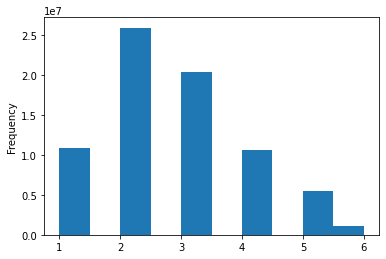

In [0]:
ps.options.plotting.backend = "matplotlib"

psdf['age'].hist()

In [0]:
psdf.columns

Out[16]: Index(['region_name', 'cpe_manufacturer_name', 'cpe_model_name', 'cpe_type_cd',
       'cpe_model_os_type', 'price', 'part_of_day', 'request_cnt', 'url',
       'dayofweek', 'month', 'quarter', 'season', 'age', 'size', 'coord'],
      dtype='object')

In [0]:
len(psdf)

Out[17]: 74210269

# Splitting

In [0]:
DF_PART = 5

In [0]:
df = sdf.sample(fraction=0.5).limit(sdf.count()//DF_PART)

In [0]:
df.count()

Out[10]: 14842053

In [0]:
df = df.select([x for x in df.columns if x != "age"] + ['age'])

In [0]:
psdf = df.toPandas()

# Modeling

In [0]:
from pyspark.mllib.classification import LogisticRegressionModel
from pyspark.mllib.tree import RandomForest
from pyspark.ml.classification import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import *
# !pip install catboost
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
import sklearn.metrics as m

## Catboost

In [0]:
X = psdf[psdf.columns[:-1]]
y = psdf['age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [0]:
test_data = catboost_pool = Pool(X_train, 
    y_train)

model = CatBoostClassifier(iterations=30,
depth=16,
learning_rate=0.1,
loss_function='MultiClass',
verbose=True)
# train the model
model.fit(X_train, y_train)
print(m.classification_report(y_test, model.predict(X_test), \
target_names = ['18-25','25-34', '35-44', '45-54', '55-65', '65+']))

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-363235728717210> in <cell line: 1>()
----> 1 test_data = catboost_pool = Pool(X_train, 
      2     y_train)
      3 
      4 model = CatBoostClassifier(iterations=30,
      5 depth=16,

NameError: name 'Pool' is not defined

## Spark MLLib

In [0]:
assembler = VectorAssembler(
    inputCols=df.columns[:-1],
    outputCol="features")
transformed_df = assembler.transform(df)

In [0]:
transformed_df = transformed_df.select(['features', 'age'])

In [0]:
train, test = transformed_df.randomSplit([0.7, 0.3], seed=42)

In [0]:
dt = DecisionTreeClassifier(labelCol="age", featuresCol="features")

In [0]:
pipeline = Pipeline(stages=[dt])

In [0]:
model = pipeline.fit(train)

In [0]:
predictions = model.transform(test)

In [0]:
evaluator = MulticlassClassificationEvaluator(labelCol="age", predictionCol="prediction" , metricName="f1")
f1 = evaluator.evaluate(predictions)

In [0]:
f1

Out[93]: 0.28319746748931285